In [1]:
from time import sleep
from datetime import datetime
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import os
import pickle
import ast
import shap
import matplotlib.pyplot as plt
from joblib import dump, load
%matplotlib inline

In [2]:
# with open("../ip_filtered_features.pkl", "rb") as f:
#     pickle.load(f)
df = pd.read_csv('../../NetML_nPrints_AMIR.csv')

In [3]:
df_nprints = df.iloc[:, 8:]
df_nprints.shape

(2394, 2667)

In [4]:
df['feat_netml'] = df['feat_netml'].apply(lambda x: np.fromstring(x.replace("[", "").replace("]", "").replace("\n", " "), sep=' '))
df['device'] = df['device'].astype('category').cat.codes

In [5]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_X_train = np.vstack(df_train['feat_netml'].values)
df_Y_train = df_train[['device', 'user']]
df_X_test = np.vstack(df_test['feat_netml'].values)
df_Y_test = df_test[['device', 'user']]

In [6]:
source_model = RandomForestClassifier(random_state=42)
source_model.fit(df_X_train, df_Y_train.iloc[:, 0].to_numpy())
# source_model_fi = source_model.feature_importances_

RandomForestClassifier(random_state=42)

In [7]:
threat_model = RandomForestClassifier(random_state=42)
threat_model.fit(df_X_train, df_Y_train.iloc[:, 1].to_numpy())
# threat_model_fi = threat_model.feature_importances_

RandomForestClassifier(random_state=42)

In [8]:
threat_pred = threat_model.predict(df_X_test)
act_pred = source_model.predict(df_X_test)

threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier

base_ident = threat_score
base_acc = act_score

base_acc, base_ident

(0.9561586638830898, 0.6951983298538622)

In [9]:
base_acc, base_ident = (0.9561586638830898, 0.6951983298538622)


In [92]:
df_X_train.shape

(1915, 36)

In [7]:
# from joblib import dump, load
# source_model_fi = load('../iot_nprint_3pkts_source_model_fi.joblib')
# threat_model_fi = load('../iot_nprint_3pkts_threat_model_fi.joblib')

In [10]:
def compute_relative_effectiveness(ident, acc, base_ident, base_acc):
    numerator = ident - base_ident
    denominator = acc - base_acc
    if denominator == 0:
        return np.nan  # Avoid division by zero
    return np.log(numerator / denominator)

def plot_both_accuracies(score_list, legend_name):
    releff_list = [
        compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
        for row in score_list
    ]
        
    plt.figure(figsize=(10, 6))

    plt.plot(score_list[:, 0], releff_list, 'ro', label=legend_name)
#     plt.scatter(1-score_list[:, 2], score_list[:, 1])

    plt.title(f'# features vs. Relative Effectiveness')
    plt.xlabel('Number of features')
    plt.ylabel('Relative Effectiveness')
    # plt.ylim(0, 1.1)
    # plt.xlim(0, 1.1)

    # Adding a legend
    plt.legend()

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig(f'{legend_name}.png')
    plt.show()

In [11]:
df_X_train.shape

(1915, 36)

In [12]:
df_Y_train.shape

(1915, 2)

In [13]:
df_X_test.shape

(479, 36)

In [14]:
df_Y_train

,device,user
1036,4,7
2205,3,7
1173,4,7
1402,0,7
507,2,7
...,...,...
1638,0,0
1095,4,7
1130,4,7
1294,4,0


In [15]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.datasets import load_iris
from scipy.stats import entropy
import numpy as np

# Compute mutual information for utility score
utility_scores = mutual_info_classif(df_X_train, df_Y_train.iloc[:, 0].to_numpy())
print("Utility Scores (Mutual Information):", utility_scores)

# Function to compute the entropy of a feature
def compute_feature_entropy(feature):
    p, _ = np.histogram(feature, bins=10, density=True)
    p = p[p > 0]  # Remove zero entries to avoid log(0) issues
    return entropy(p)

# Function to compute privacy scores
def compute_privacy_scores(X):
    privacy_scores = []
    original_entropies = [compute_feature_entropy(X[:, i]) for i in range(X.shape[1])]
    total_original_entropy = sum(original_entropies)

    for i in range(X.shape[1]):
        # Compute the entropy of the dataset without the i-th feature
        sanitized_entropies = original_entropies[:i] + original_entropies[i+1:]
        total_sanitized_entropy = sum(sanitized_entropies)
        # Privacy score is the decrease in entropy
        privacy_score = total_original_entropy - total_sanitized_entropy
        privacy_scores.append(privacy_score)
    return privacy_scores

# Compute privacy scores
privacy_scores = compute_privacy_scores(df_X_train)
print("Privacy Scores (Entropy-Based):", privacy_scores)


# Normalize scores for combining
utility_scores_normalized = np.array(utility_scores) / np.max(utility_scores)
privacy_scores_normalized = np.array(privacy_scores) / np.max(privacy_scores)

# Combine utility and privacy scores to compute trade-off scores
def trade_off_score(utility_scores, privacy_scores):
    return [(u + p) / 2 for u, p in zip(utility_scores_normalized, privacy_scores_normalized)]

# Compute trade-off scores
trade_off_scores = trade_off_score(utility_scores, privacy_scores)
print("Trade-Off Scores:", trade_off_scores)


Utility Scores (Mutual Information): [0.3823378  0.71082789 0.68187095 0.90908703 0.96695367 1.07091204
 1.15994061 1.20080108 0.38774273 1.15542758 0.71984254 0.6601471
 0.79973253 0.80040169 0.74610009 0.76952369 0.63199655 0.8229736
 0.43251754 0.73936608 0.7126512  1.02804019 1.03555805 0.77096337
 0.85830026 1.06599579 0.51776233 1.17612043 0.72059826 0.66289498
 0.81679134 0.82856235 0.74931578 0.69871019 0.65817294 0.79649586]
Privacy Scores (Entropy-Based): [0.004468517890103385, 0.008936762951975652, 0.2375720139324784, 1.3864469419267103, 0.9835158448197987, 0.7385975293547418, 0.9250188341525494, 1.2650054390414418, 0.3054506925726699, 0.7539116924577627, 0.626906106001293, 1.303855630613615, 0.2951812134133647, 0.4402853634850956, 0.8296314895915096, 0.1336398394341387, 0.17081916568085376, 0.09948108594743843, 0.004468517890103385, 0.011683671405400275, 0.012680821538502585, 0.3263859760414647, 0.8333359497887827, 0.283351124096729, 0.2869062031953433, 0.32605692902195216,

In [16]:
dump(utility_scores, 'iot_nprint_3pkts_utility_scores-stats.joblib')
dump(privacy_scores, 'iot_nprint_3pkts_privacy_scores-stats.joblib')
dump(trade_off_scores, 'iot_nprint_3pkts_trade_off_scores-stats.joblib')

['iot_nprint_3pkts_trade_off_scores-stats.joblib']

In [17]:
# Function to remove features with the lowest n scores
def remove_lowest_features(X, scores, n):
    # Get the indices of the features sorted by score
    sorted_indices = np.argsort(scores)
    # Get the indices of the features to remove
    indices_to_remove = sorted_indices[:n]
    # Remove the features from X
    X_modified = np.delete(X, indices_to_remove, axis=1)
    return X_modified


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:51<00:00,  1.48s/it]
/tmp/ipykernel_3112387/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)
/tmp/ipykernel_3112387/1236790252.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(numerator / denominator)


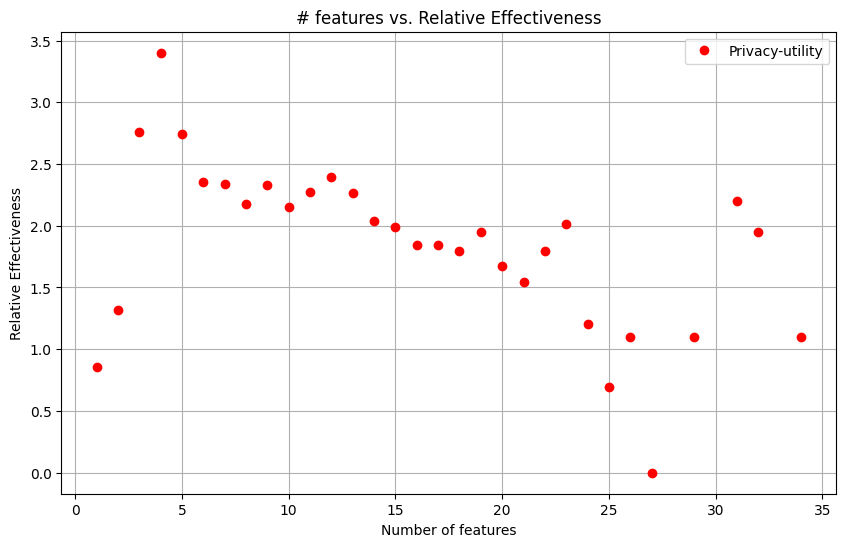

In [18]:
# Privacy-utility score
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_to_remove in tqdm(range(1, len(trade_off_scores))):
        opt_df_X_train = remove_lowest_features(df_X_train, trade_off_scores, n_to_remove)
        opt_df_X_test = remove_lowest_features(df_X_test, trade_off_scores, n_to_remove)
    
        rfc_act = RandomForestClassifier(random_state=42)
        rfc_act.fit(opt_df_X_train, df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier(random_state=42)
        rfc_threat.fit(opt_df_X_train, df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(opt_df_X_test)
        act_pred = rfc_act.predict(opt_df_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([opt_df_X_train.shape[1], act_score, threat_score])

np.savetxt(f'iot_nprint_3pkts-privacy-utility.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Privacy-utility')

100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:54<00:00,  1.54s/it]
/tmp/ipykernel_3112387/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)


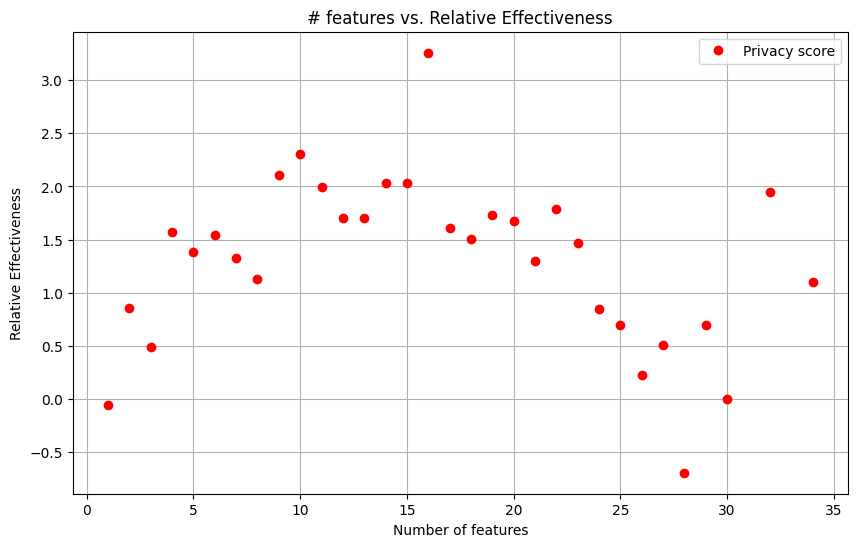

In [19]:
# Privacy score
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_to_remove in tqdm(range(1, len(privacy_scores))):
        opt_df_X_train = remove_lowest_features(df_X_train, privacy_scores, n_to_remove)
        opt_df_X_test = remove_lowest_features(df_X_test, privacy_scores, n_to_remove)
    
        rfc_act = RandomForestClassifier(random_state=42)
        rfc_act.fit(opt_df_X_train, df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier(random_state=42)
        rfc_threat.fit(opt_df_X_train, df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(opt_df_X_test)
        act_pred = rfc_act.predict(opt_df_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([opt_df_X_train.shape[1], act_score, threat_score])

np.savetxt(f'iot_nprint_3pkts-privacy-score.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Privacy score')

100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:47<00:00,  1.36s/it]
/tmp/ipykernel_3112387/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)
/tmp/ipykernel_3112387/1236790252.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(numerator / denominator)


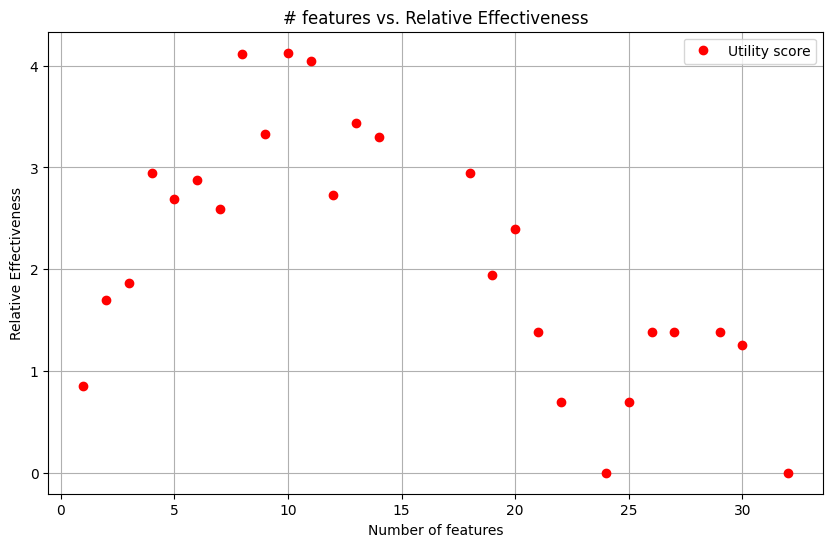

In [20]:
# Feature utility score
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_to_remove in tqdm(range(1, len(utility_scores))):
        opt_df_X_train = remove_lowest_features(df_X_train, utility_scores, n_to_remove)
        opt_df_X_test = remove_lowest_features(df_X_test, utility_scores, n_to_remove)
    
        rfc_act = RandomForestClassifier(random_state=42)
        rfc_act.fit(opt_df_X_train, df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier(random_state=42)
        rfc_threat.fit(opt_df_X_train, df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(opt_df_X_test)
        act_pred = rfc_act.predict(opt_df_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([opt_df_X_train.shape[1], act_score, threat_score])

np.savetxt(f'iot_nprint_3pkts-utility-score.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Utility score')

In [21]:
from sklearn.feature_extraction import FeatureHasher

def feature_hashing(df, n_features):
    # Convert DataFrame to a list of dictionaries
    # data_dict = df.to_dict(orient='records')
    data_dict = [dict(zip(map(str, range(df.shape[1])), row)) for row in df]

    # Initialize FeatureHasher
    hasher = FeatureHasher(n_features=n_features, input_type='dict')

    # Transform data
    hashed_features = hasher.transform(data_dict).toarray()

    # Convert hashed features to DataFrame if needed
    hashed_df = pd.DataFrame(hashed_features)
    return hashed_df

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

def pca_reduction(df, n_components):
    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df)
    
    # Initialize PCA
    pca = PCA(n_components=n_components)
    
    # Fit and transform the data
    pca_features = pca.fit_transform(scaled_features)
    
    # Convert PCA features to DataFrame
    pca_df = pd.DataFrame(pca_features)
    return pca_df


In [23]:
def plot_multiple_accuracies(score_lists, legend_names):
    plt.figure(figsize=(10, 6))
    
    # Define a list of colors for different plots
    colors = ['ro-', 'bo-', 'go-', 'co-', 'mo-', 'yo-', 'r--', 'b--', 'g--']
    marker_size = 2

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        plt.plot(1 - score_list[:, 2], score_list[:, 1], color, label=legend_name, markersize=marker_size)
    
    plt.title('Comparison of Threat vs. Source Models Accuracy')
    plt.xlabel('1-threat accuracy')
    plt.ylabel('Source model accuracy')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
             bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='lower center')

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('comparison_plot.png')
    plt.show()


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:58<00:00,  1.69s/it]
/tmp/ipykernel_3112387/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)


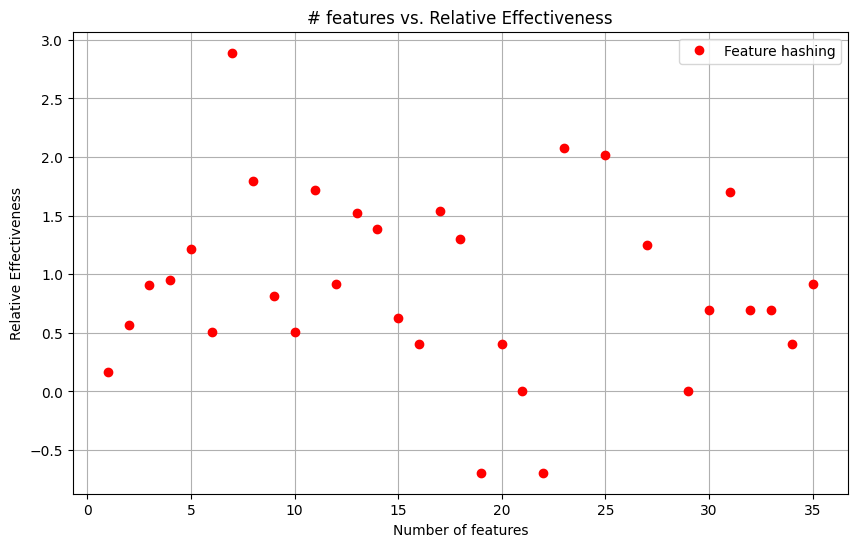

In [24]:
# Feature hashing
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_features in tqdm(range(1, df_X_train.shape[1], 1)):
        hashed_X_train = feature_hashing(df_X_train, n_features)
        hashed_X_test = feature_hashing(df_X_test, n_features)

        rfc_act = RandomForestClassifier(random_state=42)
        rfc_act.fit(hashed_X_train.to_numpy(), df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier(random_state=42)
        rfc_threat.fit(hashed_X_train.to_numpy(), df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(hashed_X_test)
        act_pred = rfc_act.predict(hashed_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([n_features, act_score, threat_score])

np.savetxt(f'iot_nprint_3pkts-feature_hashing.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Feature hashing')

100%|███████████████████████████████████████████████████████████████████████████████████| 33/33 [01:11<00:00,  2.15s/it]


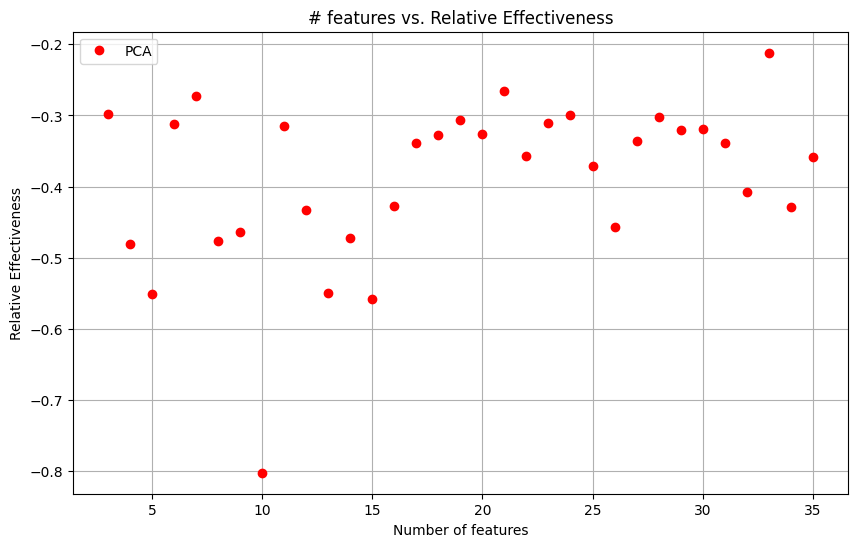

In [26]:
# PCA dimensionality reduction
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_features in tqdm(range(3,df_X_train.shape[1])):
        reduced_X_train = pca_reduction(df_X_train, n_features)
        reduced_X_test = pca_reduction(df_X_test, n_features)

        rfc_act = RandomForestClassifier(random_state=42)
        rfc_act.fit(reduced_X_train.to_numpy(), df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier(random_state=42)
        rfc_threat.fit(reduced_X_train.to_numpy(), df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(reduced_X_test)
        act_pred = rfc_act.predict(reduced_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([reduced_X_train.shape[1], act_score, threat_score])

np.savetxt(f'iot_nprint_3pkts-pca_reduction.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'PCA')

100%|███████████████████████████████████████████████████████████████████████████████████| 33/33 [50:42<00:00, 92.20s/it]


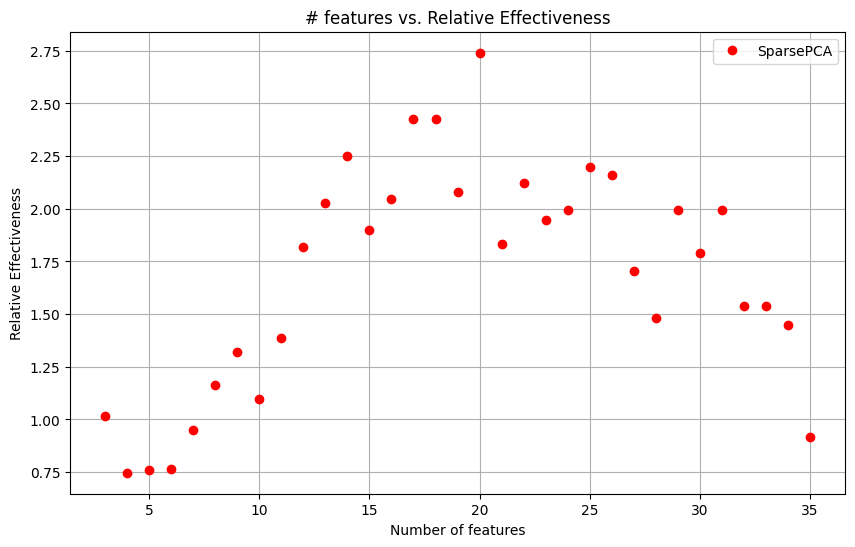

In [27]:
from sklearn.decomposition import SparsePCA

# SparsePCA dimensionality reduction
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_features in tqdm(range(3,df_X_train.shape[1])):
        transformer = SparsePCA(n_components=n_features, random_state=42)
        transformer.fit(df_X_train)
        reduced_X_train = transformer.transform(df_X_train)
        reduced_X_test = transformer.transform(df_X_test)

        rfc_act = RandomForestClassifier(random_state=42)
        rfc_act.fit(reduced_X_train, df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier(random_state=42)
        rfc_threat.fit(reduced_X_train, df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(reduced_X_test)
        act_pred = rfc_act.predict(reduced_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1], threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0], act_pred) # Network Intrusion classifier
        score_list.append([reduced_X_train.shape[1], act_score, threat_score])

np.savetxt(f'iot_nprint_3pkts-sparse_pca.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'SparsePCA')

In [28]:
def add_laplace_noise(df, epsilon):
    # Define the scale of the Laplace noise
    scale = 1.0 / epsilon
    
    # Create a noise matrix with the same shape as the DataFrame
    noise = np.random.laplace(loc=0, scale=scale, size=df.shape)
    
    # Add the noise to the original DataFrame
    noisy_df = df + noise
    
    # Convert the result back to a DataFrame
    noisy_df = pd.DataFrame(noisy_df, columns=df.columns)
    return noisy_df

In [29]:
# Differential privacy: laplace noise
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for epsilon in tqdm([0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]):
        noisy_X_train = add_laplace_noise(df_X_train, epsilon)
        noisy_X_test = add_laplace_noise(df_X_test, epsilon)

        rfc_act = RandomForestClassifier(random_state=42)
        rfc_act.fit(noisy_X_train, df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier(random_state=42)
        rfc_threat.fit(noisy_X_train, df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(noisy_X_test)
        act_pred = rfc_act.predict(noisy_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([epsilon, act_score, threat_score])

np.savetxt(f'iot_nprint_3pkts-differential_privacy.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Differential privacy')

  0%|                                                                                             | 0/9 [00:00<?, ?it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [48]:
from sklearn.metrics import accuracy_score
from joblib import dump, load
def get_accuracy_for_both_models(perc, df_X_train, df_X_test, df_Y_train, df_Y_test, threat_model_fi, source_model_fi):
    ratio = threat_model_fi / (1+source_model_fi)
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, 100-perc)
    if perc == 100:
        threshold = 0 # np.inf
    print("Both score:", ratio)
    feat_idx = np.where(threat_model_fi / (1+source_model_fi) >= threshold)[0]
    print("Features for both:", feat_idx)
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train[:, feat_idx]
    new_test = df_X_test[:, feat_idx]
    
    new_threat_model = RandomForestClassifier(random_state=42)
    new_threat_model.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())

    new_source_model = RandomForestClassifier(random_state=42)
    new_source_model.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())

    ip_pred_new = new_threat_model.predict(new_test)
    act_pred_new = new_source_model.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier

    return len(feat_idx), threat_score, y_score


def get_accuracy_for_source_models(perc, df_X_train, df_X_test, df_Y_train, df_Y_test, threat_model_fi, source_model_fi):
    ratio = source_model_fi
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, 100-perc)
    if perc == 100:
        threshold = 0 # np.inf
    print("Both score:", ratio)
    feat_idx = np.where(source_model_fi >= threshold)[0]
    print("Features for both:", feat_idx)
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train[:, feat_idx]
    new_test = df_X_test[:, feat_idx]
    
    new_threat_model = RandomForestClassifier(random_state=42)
    new_threat_model.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())

    new_source_model = RandomForestClassifier(random_state=42)
    new_source_model.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())

    ip_pred_new = new_threat_model.predict(new_test)
    act_pred_new = new_source_model.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier

    return len(feat_idx), threat_score, y_score

def get_accuracy_for_threat_models(perc, df_X_train, df_X_test, df_Y_train, df_Y_test, threat_model_fi, source_model_fi):
    ratio = threat_model_fi
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, perc)
    if perc == 100:
        threshold = np.inf
    print("Both score:", ratio)
    feat_idx = np.where(threat_model_fi <= threshold)[0]
    print("Features for both:", feat_idx)
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train[:, feat_idx]
    new_test = df_X_test[:, feat_idx]
    
    new_threat_model = RandomForestClassifier(random_state=42)
    new_threat_model.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())

    new_source_model = RandomForestClassifier(random_state=42)
    new_source_model.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())

    ip_pred_new = new_threat_model.predict(new_test)
    act_pred_new = new_source_model.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier

    return len(feat_idx), threat_score, y_score

source_model = RandomForestClassifier(random_state=42)
source_model.fit(df_X_train, df_Y_train.iloc[:, 0].to_numpy())
source_model_fi = rfc_act.feature_importances_

threat_model = RandomForestClassifier(random_state=42)
threat_model.fit(df_X_train, df_Y_train.iloc[:, 1].to_numpy())
threat_model_fi = rfc_threat.feature_importances_

# dump(source_model_fi, 'serv_rec_full_nprint_10pkts_source_model_fi.joblib')
# dump(threat_model_fi, 'serv_rec_full_nprint_10pkts_threat_model_fi.joblib')
# source_model_fi = load('serv_rec_full_nprint_10pkts_source_model_fi.joblib')
# threat_model_fi = load('serv_rec_full_nprint_10pkts_threat_model_fi.joblib')

score_list_both = []
for perc in [0.03,0.1,0.3,1,3,5,7,9,10,20,30,40,50,60,70,80,90,100]:
    len_feat_i, threat_score_i, y_score_i = get_accuracy_for_both_models(perc, df_X_train, df_X_test, df_Y_train, df_Y_test, threat_model_fi, source_model_fi)
    score_list_both.append([len_feat_i, y_score_i, threat_score_i])

np.savetxt(f'impurity.score_list_both_random_forest.csv', np.array(score_list_both), delimiter=",")

score_list_source = []
for perc in [0.03,0.1,0.3,1,3,10,30,100]:
    len_feat_i, threat_score_i, y_score_i = get_accuracy_for_source_models(perc, df_X_train, df_X_test, df_Y_train, df_Y_test, threat_model_fi, source_model_fi)
    score_list_source.append([len_feat_i, y_score_i, threat_score_i])

np.savetxt(f'impurity.score_list_source_random_forest.csv', np.array(score_list_source), delimiter=",")

score_list_threat = []
for perc in [0.03,0.1,0.3,1,3,10,30,100]:
    len_feat_i, threat_score_i, y_score_i = get_accuracy_for_threat_models(perc, df_X_train, df_X_test, df_Y_train, df_Y_test, threat_model_fi, source_model_fi)
    score_list_threat.append([len_feat_i, y_score_i, threat_score_i])

np.savetxt(f'impurity.score_list_threat_random_forest.csv', np.array(score_list_threat), delimiter=",")

Both score: [0.02802467 0.03884114 0.02701497 0.03486367 0.02942899 0.05195794
 0.04191384 0.02249905 0.02696508 0.03101934 0.02346418 0.02451482
 0.02294528 0.02905934 0.02805497 0.03121893 0.03266986 0.02370573
 0.02672098 0.02742193 0.01750084 0.02829863 0.01856461 0.02306721
 0.02105052 0.03098329 0.02253558 0.02186882 0.02695763 0.02133032
 0.03373351 0.02567072 0.03111964 0.02337745 0.02288843]
Features for both: [5]
Percentile of features to keep: 0.03; Number of features to keep: 1; Ratio Threshold: 0.051855487844740214
Both score: [0.02802467 0.03884114 0.02701497 0.03486367 0.02942899 0.05195794
 0.04191384 0.02249905 0.02696508 0.03101934 0.02346418 0.02451482
 0.02294528 0.02905934 0.02805497 0.03121893 0.03266986 0.02370573
 0.02672098 0.02742193 0.01750084 0.02829863 0.01856461 0.02306721
 0.02105052 0.03098329 0.02253558 0.02186882 0.02695763 0.02133032
 0.03373351 0.02567072 0.03111964 0.02337745 0.02288843]
Features for both: [5]
Percentile of features to keep: 0.1; Nu

In [63]:
# 2024-06-24: fix nan issue with np.percentile
def get_accuracy_for_both_models(perc, df_X_train, df_Y_train, x_src_ip, y_value):
    ratio = x_src_ip / y_value
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, perc)
    if perc == 100:
        threshold = np.inf
    feat_idx = np.where(x_src_ip / y_value < threshold)[0]
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    print(f"Features selected: {feat_idx}")
    new_train = df_X_train[:, feat_idx]
    new_test = df_X_test[:, feat_idx]
    rfc_src_ip_noise = RandomForestClassifier(random_state=42)
#     rfc_src_ip_noise = SVC(probability=True)
    rfc_src_ip_noise.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())
#     dump(rfc_src_ip, f'rfc_src_ip_by_subnet_noise_perc_{perc}.joblib')

    rfc_label = RandomForestClassifier(random_state=42)
#     rfc_label = SVC(probability=True)
    rfc_label.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())
#     dump(rfc_label, f'rfc_label_by_subnet_noise_perc_{perc}_by_src_ip.joblib')
    
    ip_pred_new = rfc_src_ip_noise.predict(new_test)
    act_pred_new = rfc_label.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier
    
    # Compute class-wise accuracies and confidence intervals
#     threat_class_accuracies, threat_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_class_accuracies, source_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    # Compute overall confidence intervals
#     threat_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    
#     cdf_classwise_accuracy(perc, df_Y_test, ip_pred_new, act_pred_new)
    return len(feat_idx), threat_score, y_score


def get_accuracy_for_threat_model(perc, df_X_train, df_Y_train, x_src_ip, y_value):
    ratio = x_src_ip
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, perc)
    
    if perc == 100:
        threshold = np.inf
    if threshold == 0:
        threshold = min(ratio[ratio != 0])
    print(threshold)
    feat_idx = np.where(x_src_ip < threshold)[0]
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    print(f"Features selected: {feat_idx}")
    new_train = df_X_train[:, feat_idx]
    new_test = df_X_test[:, feat_idx]
    rfc_src_ip_noise = RandomForestClassifier(random_state=42)
#     rfc_src_ip_noise = SVC(probability=True)
    rfc_src_ip_noise.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())
#     dump(rfc_src_ip, f'rfc_src_ip_by_subnet_noise_perc_{perc}.joblib')

    rfc_label = RandomForestClassifier(random_state=42)
#     rfc_label = SVC(probability=True)
    rfc_label.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())
#     dump(rfc_label, f'rfc_label_by_subnet_noise_perc_{perc}_by_src_ip.joblib')
    
    ip_pred_new = rfc_src_ip_noise.predict(new_test)
    act_pred_new = rfc_label.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier

    # Compute class-wise accuracies and confidence intervals
#     threat_class_accuracies, threat_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_class_accuracies, source_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    # Compute overall confidence intervals
#     threat_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    
#     cdf_classwise_accuracy(perc, df_Y_test, ip_pred_new, act_pred_new)
    return len(feat_idx), threat_score, y_score


def get_accuracy_for_source_model(perc, df_X_train, df_Y_train, x_src_ip, y_value):
    ratio = y_value
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(-ratio, perc)
    if perc == 100:
        threshold = np.inf
    if threshold == 0:
        threshold = min(ratio[ratio != 0])
    print(threshold)
    feat_idx = np.where(y_value > -threshold)[0]
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    print(f"Features selected: {feat_idx}")
    new_train = df_X_train[:, feat_idx]
    new_test = df_X_test[:, feat_idx]
    rfc_src_ip_noise = RandomForestClassifier(random_state=42)
#     rfc_src_ip_noise = SVC(probability=True)
    rfc_src_ip_noise.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())
#     dump(rfc_src_ip, f'rfc_src_ip_by_subnet_noise_perc_{perc}.joblib')

    rfc_label = RandomForestClassifier(random_state=42)
#     rfc_label = SVC(probability=True)
    rfc_label.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())
#     dump(rfc_label, f'rfc_label_by_subnet_noise_perc_{perc}_by_src_ip.joblib')
    
    ip_pred_new = rfc_src_ip_noise.predict(new_test)
    act_pred_new = rfc_label.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier
    
    # Compute class-wise accuracies and confidence intervals
#     threat_class_accuracies, threat_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_class_accuracies, source_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    # Compute overall confidence intervals
#     threat_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    
#     cdf_classwise_accuracy(perc, df_Y_test, ip_pred_new, act_pred_new)
    return len(feat_idx), threat_score, y_score




In [64]:
def shap_feature_selection(df_X_train, df_Y_train, custom_text=''):
    rfc_act = RandomForestClassifier(random_state=42)
    rfc_act.fit(df_X_train, df_Y_train.iloc[:, 0].to_numpy())

    rfc_threat = RandomForestClassifier(random_state=42)
    rfc_threat.fit(df_X_train, df_Y_train.iloc[:, 1].to_numpy())

    if os.path.exists(f'shap_values_act_{custom_text}.joblib'):
        shap_values_act = load(f'shap_values_act_{custom_text}.joblib')
    else:
        explainer_act = shap.Explainer(rfc_act)
        shap_values_act = explainer_act(df_X_train)
        dump(shap_values_act, f'shap_values_act_{custom_text}.joblib')
    y_value = np.mean(np.amax(np.absolute(shap_values_act.values), axis=2), axis=0)

    if os.path.exists(f'shap_values_threat_{custom_text}.joblib'):
        shap_values_threat = load(f'shap_values_threat_{custom_text}.joblib')
    else:
        explainer_threat = shap.Explainer(rfc_threat)
        shap_values_threat = explainer_threat(df_X_train)
        dump(shap_values_threat, f'shap_values_threat_{custom_text}.joblib')
    x_src_ip = np.mean(np.amax(np.absolute(shap_values_threat.values), axis=2), axis=0)

    score_list_both = []
    score_list_threat = []
    score_list_source = []

    for perc in [3,5,7,9,10,20,30,40,50,60,70,80,90,100]:
        len_feat_i_threat, threat_score_i_threat, y_score_i_threat = get_accuracy_for_threat_model(perc, df_X_train, df_Y_train, x_src_ip, y_value)
        score_list_threat.append([len_feat_i_threat, y_score_i_threat, threat_score_i_threat])

        len_feat_i_source, threat_score_i_source, y_score_i_source = get_accuracy_for_source_model(perc, df_X_train, df_Y_train, x_src_ip, y_value)
        score_list_source.append([len_feat_i_source, y_score_i_source, threat_score_i_source])
        
        len_feat_i, threat_score_i, y_score_i = get_accuracy_for_both_models(perc, df_X_train, df_Y_train, x_src_ip, y_value)
        score_list_both.append([len_feat_i, y_score_i, threat_score_i])

    np.savetxt(f'shap_{custom_text}.score_list_both.csv', np.array(score_list_both), delimiter=",")
    np.savetxt(f'shap_{custom_text}.score_list_source.csv', np.array(score_list_source), delimiter=",")
    np.savetxt(f'shap_{custom_text}.score_list_threat.csv', np.array(score_list_threat), delimiter=",")

    score_lists = [np.array(score_list_both), np.array(score_list_source), np.array(score_list_threat)]
    legend_lists = ['SHAP greedy on both', 'SHAP greedy on source', 'SHAP greedy on threat']
    plot_multiple_accuracies(score_lists, legend_lists)

0.008054866493990944
Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.008054866493990944
Features selected: [ 8 11]
-0.08583490114233414
Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: -0.08583490114233414
Features selected: [23 35]
Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.2702483516620404
Features selected: [17 35]
0.00809737630498748
Percentile of features to keep: 5; Number of features to keep: 2; Ratio Threshold: 0.00809737630498748
Features selected: [ 8 11]
-0.07846136701969492
Percentile of features to keep: 5; Number of features to keep: 2; Ratio Threshold: -0.07846136701969492
Features selected: [23 35]
Percentile of features to keep: 5; Number of features to keep: 2; Ratio Threshold: 0.3457387168950453
Features selected: [17 35]
0.008389328765646444
Percentile of features to keep: 7; Number of features to keep: 3; Ratio Threshold: 0.008389328765646444
Features se

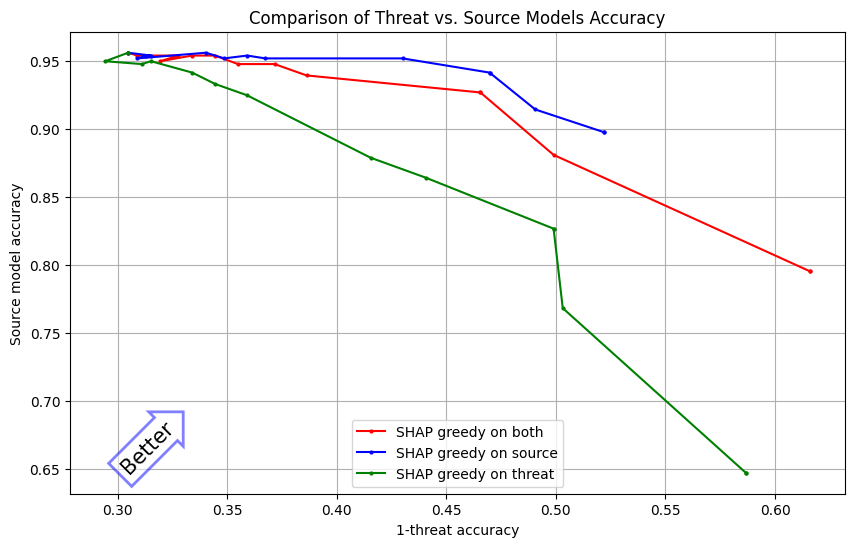

In [65]:
shap_feature_selection(df_X_train, df_Y_train, custom_text='train size:1')

In [31]:
def plot_multiple_accuracy_features(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        # releff_list = [
        #     compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
        #     for row in score_list
        # ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 0], score_list[:, 1], color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Accuracy vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Prediction Accuracy After Feature Minimization')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='lower center', fontsize=8, ncol=3)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('iot_nprint_3pkts-accuracy-features.pdf')
    plt.show()


def plot_multiple_ident_features(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        # releff_list = [
        #     compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
        #     for row in score_list
        # ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 0], score_list[:, 2], color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Identifiability vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Identifiability After Feature Minimization')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='lower center', fontsize=8, ncol=3)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('iot_nprint_3pkts-ident-features.pdf')
    plt.show()


In [32]:
def plot_multiple_releff_features(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        releff_list = [
            compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
            for row in score_list
        ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 0], releff_list, color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Relative Effectiveness vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Relative Effectiveness')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='lower left', fontsize=8, ncol=2)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('iot_nprint_3pkts-releff-comparison.pdf')
    plt.show()


In [33]:
def plot_multiple_releff_accuracies(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        releff_list = [
            compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
            for row in score_list
        ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 1], releff_list, color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Relative Effectiveness vs. Accuracy')
    plt.xlabel('Prediction Accuracy After Feature Minimization')
    plt.ylabel('Relative Effectiveness')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='upper left', fontsize=8, ncol=2)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('iot_nprint_3pkts-releff-accuracy.pdf')
    plt.show()

def plot_multiple_releff_ident(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        releff_list = [
            compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
            for row in score_list
        ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 2], releff_list, color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Relative Effectiveness vs. Identifiability')
    plt.xlabel('Identifiability After Feature Minimization')
    plt.ylabel('Relative Effectiveness')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='upper left', fontsize=8, ncol=2)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('iot_nprint_3pkts-releff-identifiability.pdf')
    plt.show()


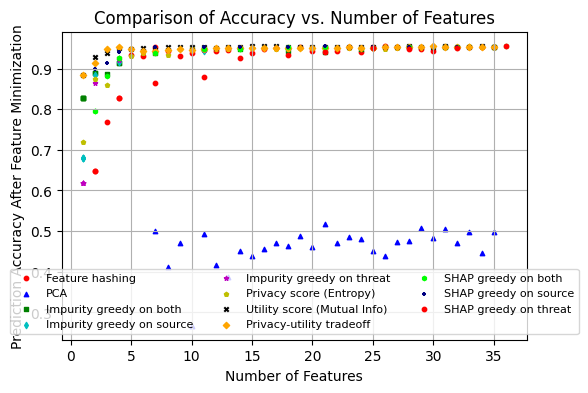

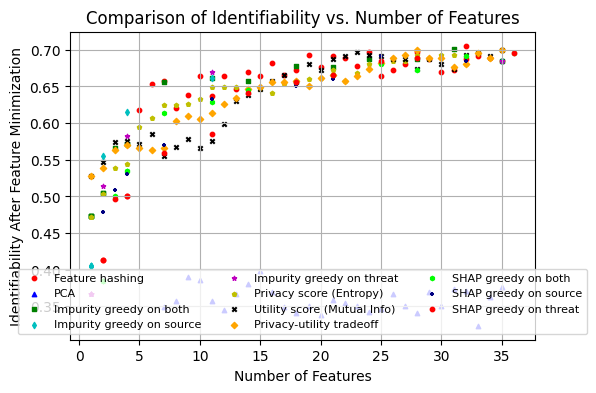

/tmp/ipykernel_3112387/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)
/tmp/ipykernel_3112387/1236790252.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(numerator / denominator)


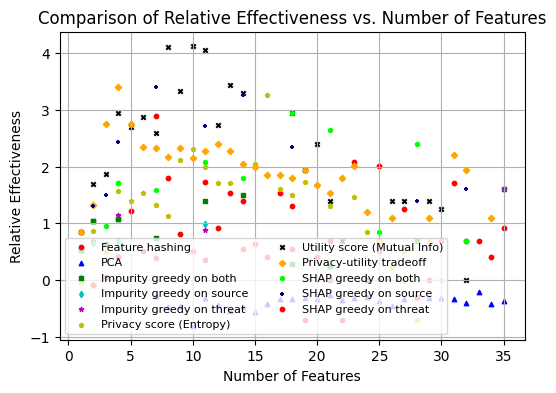

/tmp/ipykernel_3112387/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)
/tmp/ipykernel_3112387/1236790252.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(numerator / denominator)


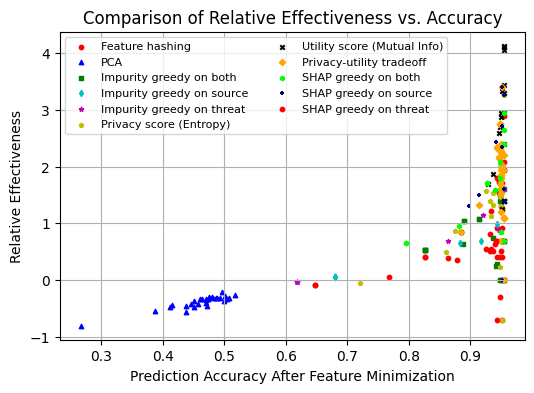

/tmp/ipykernel_3112387/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)
/tmp/ipykernel_3112387/1236790252.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(numerator / denominator)


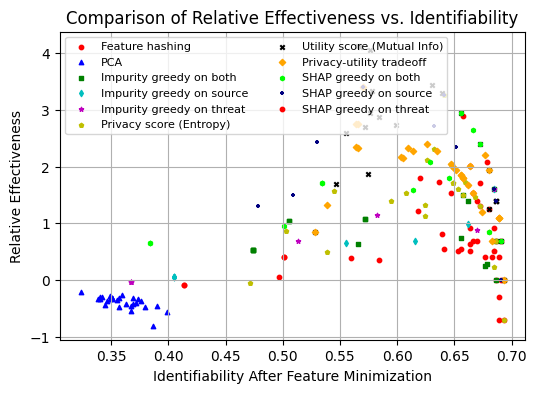

In [69]:
score_list_fh = np.loadtxt(f'iot_nprint_3pkts-feature_hashing.csv', delimiter=",")
score_list_pca = np.loadtxt(f'iot_nprint_3pkts-pca_reduction.csv', delimiter=",")
# score_list_dp = np.loadtxt(f'iot_nprint_3pkts-differential_privacy-features.csv', delimiter=",")
score_list_privacy = np.loadtxt(f'iot_nprint_3pkts-privacy-score.csv', delimiter=",")
score_list_utility = np.loadtxt(f'iot_nprint_3pkts-utility-score.csv', delimiter=",")
score_list_privacy_utility = np.loadtxt(f'iot_nprint_3pkts-privacy-utility.csv', delimiter=",")

custom_text='train size:1'
score_list_both = np.loadtxt(f'shap_{custom_text}.score_list_both.csv', delimiter=",")
score_list_source = np.loadtxt(f'shap_{custom_text}.score_list_source.csv', delimiter=",")
score_list_threat = np.loadtxt(f'shap_{custom_text}.score_list_threat.csv', delimiter=",")

score_list_impurity_both = np.loadtxt(f'impurity.score_list_both_random_forest_iot_nprint_3pkts.csv', delimiter=",")
score_list_impurity_source = np.loadtxt(f'impurity.score_list_source_random_forest_iot_nprint_3pkts.csv', delimiter=",")
score_list_impurity_threat = np.loadtxt(f'impurity.score_list_threat_random_forest_iot_nprint_3pkts.csv', delimiter=",")


score_lists = [score_list_fh[4:, :], score_list_pca[4:, :], #score_list_dp,
               score_list_impurity_both, score_list_impurity_source, score_list_impurity_threat,
               score_list_privacy, score_list_utility, score_list_privacy_utility,
               score_list_both, score_list_source, score_list_threat,]
legend_lists = ['Feature hashing', 'PCA', #'Differential privacy',
                'Impurity greedy on both', 'Impurity greedy on source', 'Impurity greedy on threat',
                'Privacy score (Entropy)', 'Utility score (Mutual Info)', 'Privacy-utility tradeoff',
                'SHAP greedy on both', 'SHAP greedy on source', 'SHAP greedy on threat',]

plot_multiple_accuracy_features(score_lists, legend_lists)
plot_multiple_ident_features(score_lists, legend_lists)
plot_multiple_releff_features(score_lists, legend_lists)
plot_multiple_releff_accuracies(score_lists, legend_lists)
plot_multiple_releff_ident(score_lists, legend_lists)

In [86]:
def plot_absolute_accuracy(score_list, base_accuracy, base_ident, method=''):
    # Extract values
    num_features = score_list[:, 0]
    accuracy = base_accuracy - score_list[:, 1]
    ident_diff = base_ident - score_list[:, 2]
    # y_max = max(max(accuracy), max(ident_diff))
    y_max = 0.6

    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Left y-axis for accuracy
    ax1.set_xlabel('Number of Features')
    ax1.set_ylabel('Accuracy Loss', color='tab:blue')
    ax1.plot(num_features, accuracy, 'o-', color='tab:blue', label='Accuracy')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(0, y_max)

    # Right y-axis for identification difference
    ax2 = ax1.twinx()
    ax2.set_ylabel('Identifiability Reduction', color='tab:red')
    ax2.plot(num_features, ident_diff, 's-', color='tab:red', label='Identifiability Reduction')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(0, y_max)

    # Title and grid
    plt.title(f'# Features vs. Accuracy Loss & Identifiability Reduction ({method})', fontsize=8)
    fig.tight_layout()
    plt.grid(True)

    # Save and show
    plt.savefig(f'iot_nprint_3pkts-stats-{method}.pdf')
    plt.show()



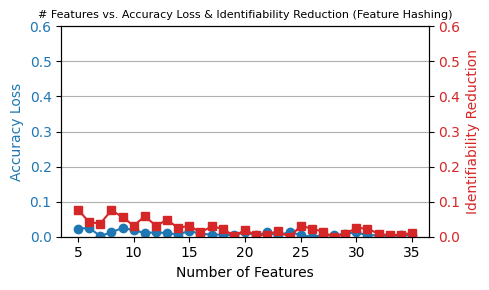

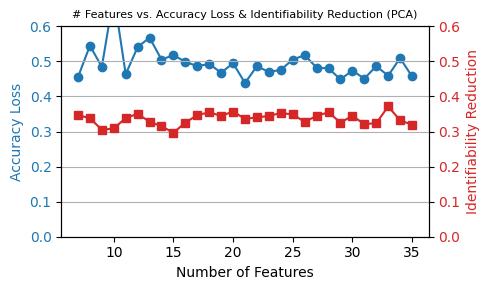

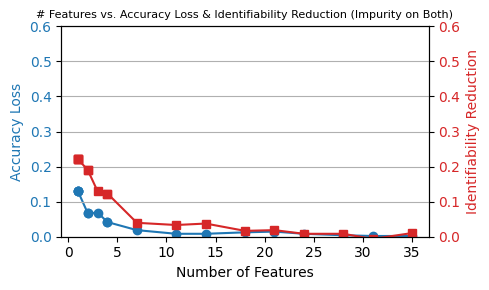

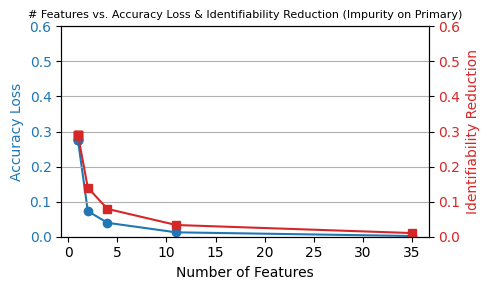

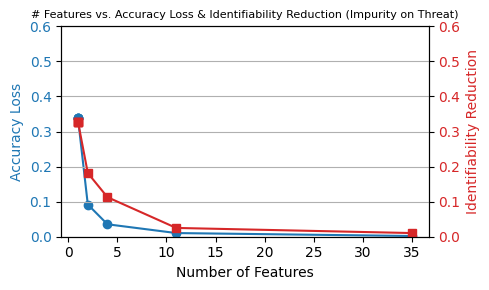

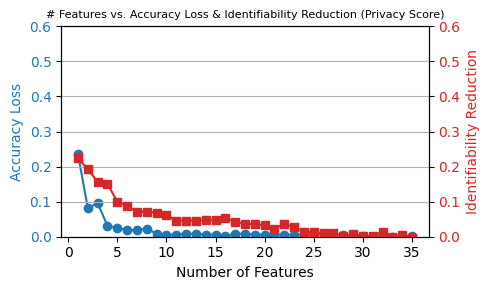

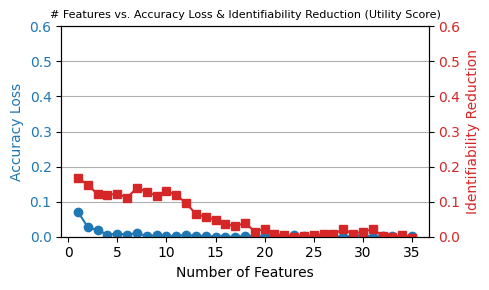

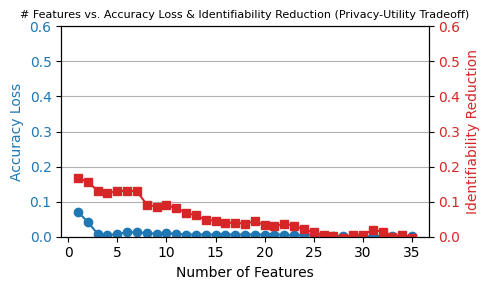

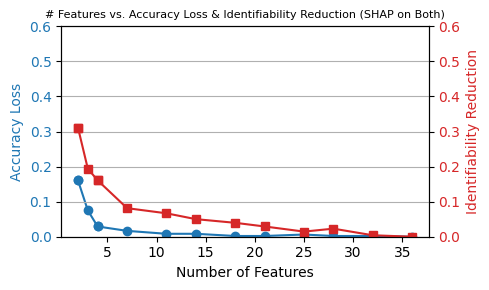

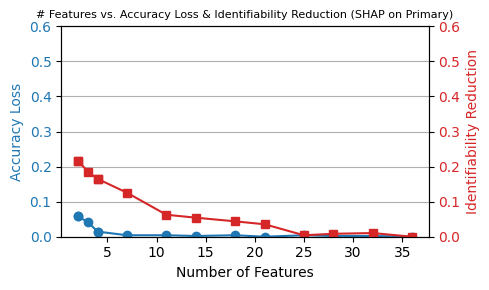

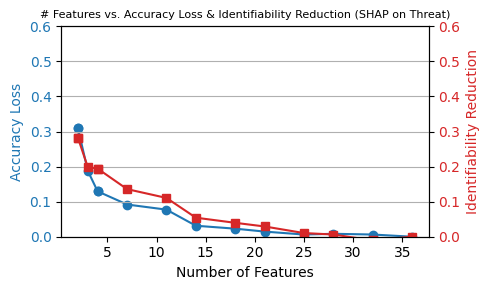

[None, None, None, None, None, None, None, None, None, None, None]

In [88]:
score_list_fh = np.loadtxt(f'iot_nprint_3pkts-feature_hashing.csv', delimiter=",")
score_list_pca = np.loadtxt(f'iot_nprint_3pkts-pca_reduction.csv', delimiter=",")
# score_list_dp = np.loadtxt(f'iot_nprint_3pkts-differential_privacy-features.csv', delimiter=",")
score_list_privacy = np.loadtxt(f'iot_nprint_3pkts-privacy-score.csv', delimiter=",")
score_list_utility = np.loadtxt(f'iot_nprint_3pkts-utility-score.csv', delimiter=",")
score_list_privacy_utility = np.loadtxt(f'iot_nprint_3pkts-privacy-utility.csv', delimiter=",")

custom_text='train size:1'
score_list_both = np.loadtxt(f'shap_{custom_text}.score_list_both.csv', delimiter=",")
score_list_source = np.loadtxt(f'shap_{custom_text}.score_list_source.csv', delimiter=",")
score_list_threat = np.loadtxt(f'shap_{custom_text}.score_list_threat.csv', delimiter=",")

score_list_impurity_both = np.loadtxt(f'impurity.score_list_both_random_forest_iot_nprint_3pkts.csv', delimiter=",")
score_list_impurity_source = np.loadtxt(f'impurity.score_list_source_random_forest_iot_nprint_3pkts.csv', delimiter=",")
score_list_impurity_threat = np.loadtxt(f'impurity.score_list_threat_random_forest_iot_nprint_3pkts.csv', delimiter=",")

score_lists = [score_list_fh[4:, :], score_list_pca[4:, :], #score_list_dp,
               score_list_impurity_both, score_list_impurity_source, score_list_impurity_threat,
               score_list_privacy, score_list_utility, score_list_privacy_utility,
               score_list_both, score_list_source, score_list_threat,]

methods = ['Feature Hashing', 'PCA', 'Impurity on Both', 'Impurity on Primary', 'Impurity on Threat',
           'Privacy Score', 'Utility Score', 'Privacy-Utility Tradeoff', 'SHAP on Both', 'SHAP on Primary', 'SHAP on Threat']
[plot_absolute_accuracy(score_list, base_acc, base_ident, method) for score_list, method in zip(score_lists, methods)]
